In [104]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()    

In [105]:
ASSET_DIR = "../data/assets/with_direction"
# Asset root for rendering. You can change this if you want to use custom game assets.
ASSET_ROOT = "../data/assets/"

In [106]:
# Rendering and display
from grid_universe.renderer.texture import TextureRenderer
from IPython.display import display
# Default renderer used throughout the notebook unless overridden in a cell
renderer = TextureRenderer(resolution=240, asset_root=ASSET_ROOT)
renderer_large = TextureRenderer(resolution=480, asset_root=ASSET_ROOT)

In [107]:
import os
import numpy as np
import torch, torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from typing import List
from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.model_selection import train_test_split
import time
import random

In [132]:
def get_model(num_classes: int) -> nn.Module:
    res = nn.Sequential(
        nn.Conv2d(4, 4, kernel_size=3, padding=1),
        nn.LeakyReLU(0.1),
        nn.BatchNorm2d(4),
        nn.MaxPool2d(2),

        nn.Flatten(),

        nn.Linear(100, 64),
        nn.LeakyReLU(0.1),
        nn.Linear(64, num_classes),
    )
    return res    

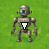

ValueError: max() iterable argument is empty

In [133]:
from PIL import Image

temp = Image.open("../IMSTUPID.png")
display(temp)
# print(detect_triangle_direction_from_image(temp, 1))
img = np.array(temp)

asd = Image.fromarray(img[15:30, 15:30, :])
display(asd)
display(print(detect_triangle_template(asd)))

In [134]:
def draw_direction_triangles_on_image(
    image: Image.Image, size: int, dx: int, dy: int, count: int
) -> Image.Image:
    """
    Draw 'count' filled triangles pointing (dx, dy) on the given RGBA image.
    Triangles are centered: the centroid of each triangle is symmetrically arranged
    around the image center. Spacing is between triangle centroids.
    """
    if count <= 0 or (dx, dy) == (0, 0):
        return image

    draw = ImageDraw.Draw(image)
    cx, cy = size // 2, size // 2

    # Triangle geometry (relative to size)
    tri_height = max(4, int(size * 0.16))
    tri_half_base = max(3, int(size * 0.10))
    spacing = max(2, int(size * 0.12))  # distance between triangle centroids

    # Axis-aligned direction and perpendicular
    ux, uy = dx, dy  # points toward the triangle tip
    px, py = -uy, ux  # perpendicular (for base width)

    # Offsets for centroids: 1 -> [0], 2 -> [-0.5s, +0.5s], 3 -> [-s, 0, +s], ...
    offsets = [(i - (count - 1) / 2.0) * spacing for i in range(count)]

    # For an isosceles triangle, the centroid lies 1/3 of the height from the base toward the tip.
    # If C is the centroid, then:
    #   tip = C + (2/3)*tri_height * u
    #   base_center = C - (1/3)*tri_height * u
    tip_offset = (2.0 / 3.0) * tri_height
    base_offset = (1.0 / 3.0) * tri_height

    for off in offsets:
        # Centroid position
        Cx = cx + int(round(ux * off))
        Cy = cy + int(round(uy * off))

        # Tip and base-center positions
        tip_x = int(round(Cx + ux * tip_offset))
        tip_y = int(round(Cy + uy * tip_offset))
        base_x = int(round(Cx - ux * base_offset))
        base_y = int(round(Cy - uy * base_offset))

        # Base vertices around base center along the perpendicular
        p1 = (tip_x, tip_y)
        p2 = (
            int(round(base_x + px * tri_half_base)),
            int(round(base_y + py * tri_half_base)),
        )
        p3 = (
            int(round(base_x - px * tri_half_base)),
            int(round(base_y - py * tri_half_base)),
        )

        draw.polygon([p1, p2, p3], fill=(255, 255, 255, 220), outline=(0, 0, 0, 220))

    return image

In [135]:
labels = ["no_direction", "right", "left", "down", "up"]
directions = [(0, 0), (1, 0), (-1, 0), (0, 1), (0, -1)]

class RandomDirection:
    def __init__(self):
        pass

    def __call__(self, image: Image.Image):
        # make image overlay with a background
        floor_dir = os.path.join(ASSET_ROOT, "imagen1", "floor")
        floor_files = [
            f for f in os.listdir(floor_dir)
            if f.lower().endswith((".png"))
        ]

        if len(floor_files) > 0:
            fname = random.choice(floor_files)
            floor_path = os.path.join(floor_dir, fname)
            with open(floor_path, "rb") as f:
                floor_img = Image.open(f).convert("RGBA")

            if floor_img.size != image.size:
                floor_img = floor_img.resize(image.size)

            bg = floor_img.copy()
            bg.paste(image, (0, 0), image)
            image = bg

        random.seed(time.time())
        decision = random.randint(0, 4)

        if decision == 0:
            return image, 0

        dx, dy = directions[decision]
        new_image: Image.Image = draw_direction_triangles_on_image(image=image, size=image.size[0], dx=dx, dy=dy, count=1)       

        return new_image, decision


In [136]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.random_direction = RandomDirection()
        self.targets = base_dataset.targets
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]
        new_image, new_label = self.random_direction(image)
        image = self.transform(new_image)
        return image, new_label


In [137]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode
def get_augmentations():
    T = transforms.Compose([
        transforms.Resize(64, interpolation=InterpolationMode.BICUBIC),
        transforms.CenterCrop((11, 11)),
        transforms.ColorJitter(
            brightness=0.3,  # ±30% brightness
            contrast=0.3,    # ±30% contrast
            saturation=0.3,  # add variety for tinted whites
            hue=0.05  
        ),
        transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 1.5))], p=0.2),
        transforms.ToTensor(),
    ])
    return T


In [138]:
ASSET_DIR = "../data/assets/with_direction"

def rgba_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert("RGBA") 

base_dataset = ImageFolder(root=ASSET_DIR, loader=rgba_loader)
dataset = CustomDataset(base_dataset, transform=get_augmentations())
print(len(dataset))

(image, label) = dataset[50]

print(labels[label])
display(image)
print(detect_triangle_direction_from_image(image, 1))


480
down


tensor([[[0.9529, 0.9098, 0.9176, 0.9137, 0.8941, 0.9059, 0.9059, 0.9020,
          0.8941, 0.9059, 0.8941],
         [0.9569, 0.9490, 0.9529, 0.9451, 0.9333, 0.9490, 0.9294, 0.9255,
          0.9176, 0.9255, 0.9294],
         [0.4745, 0.4745, 0.4824, 0.4863, 0.4745, 0.4745, 0.4706, 0.4706,
          0.4667, 0.4706, 0.4745],
         [0.4196, 0.7137, 0.8784, 0.8588, 0.8588, 0.8588, 0.8588, 0.8588,
          0.8588, 0.8627, 0.8863],
         [0.7804, 0.5059, 0.9843, 0.9843, 0.9843, 0.9843, 0.9843, 0.9843,
          0.9843, 0.9843, 0.8667],
         [0.9176, 0.6275, 0.6863, 0.9843, 0.9843, 0.9843, 0.9843, 0.9843,
          0.9843, 0.9569, 0.4745],
         [0.9059, 0.8784, 0.4431, 0.9569, 0.9843, 0.9843, 0.9843, 0.9843,
          0.9843, 0.6627, 0.5922],
         [0.9059, 0.9333, 0.6510, 0.6510, 0.9843, 0.9843, 0.9843, 0.9843,
          0.9255, 0.4667, 0.8275],
         [0.8941, 0.8902, 0.9373, 0.4745, 0.8510, 0.9843, 0.9843, 0.9843,
          0.4941, 0.7333, 0.8706],
         [0.8667, 0

AttributeError: 'Tensor' object has no attribute 'convert'

In [139]:
indices = list(range(len(dataset)))
targets = [dataset[i][1] for i in range(len(dataset))]

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.3,
    random_state=int(time.time()),
    stratify=targets
)
print(len(dataset))
train_data = Subset(dataset, train_idx)
test_data = Subset(dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

480


In [140]:
def get_accuracy(pred: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    y_pred = torch.argmax(pred, dim=1).long()
    label = label.view(-1).long() 
    return (y_pred == label).float().mean()

def get_model_accuracy(model: nn.Module):
    with torch.no_grad():
        model.eval()

        sum_acc = 0
        cnt = 0

        for x, y in test_loader:
            pred = model(x)

            sum_acc += get_accuracy(pred, y)
            cnt += 1
        
        return float(sum_acc / cnt)

        

In [141]:
def train_model(loader: torch.utils.data.DataLoader, model: nn.Module):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()  

    epoch_losses = []
    for i in range(10):
        epoch_loss = 0
        model.train()
        for _, (x, y) in enumerate(loader):
            optimiser.zero_grad()
            # x, y = x.cuda(), y.cuda()
            y_pred = model(x)
            
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()
            loss.backward()
            optimiser.step()

        epoch_loss = epoch_loss / len(loader)
        epoch_losses.append(epoch_loss)
        print("Epoch: {}, Loss: {}, Accuracy: {}".format(i, epoch_loss, get_model_accuracy(model)))
        

    return model, epoch_losses

In [142]:
model = get_model(5)
train_model(train_loader, model)

Epoch: 0, Loss: 1.4643543850291858, Accuracy: 0.2916666567325592
Epoch: 1, Loss: 1.063630374995145, Accuracy: 0.8125
Epoch: 2, Loss: 0.6895784789865668, Accuracy: 0.9652777910232544
Epoch: 3, Loss: 0.36930217119780456, Accuracy: 0.9791666865348816
Epoch: 4, Loss: 0.21712616086006165, Accuracy: 0.9930555820465088
Epoch: 5, Loss: 0.14336842704902997, Accuracy: 0.9930555820465088
Epoch: 6, Loss: 0.08499596877531572, Accuracy: 0.9930555820465088
Epoch: 7, Loss: 0.06602693416855553, Accuracy: 0.9930555820465088
Epoch: 8, Loss: 0.06449752808971838, Accuracy: 0.9861111044883728
Epoch: 9, Loss: 0.048323130743070083, Accuracy: 0.9930555820465088


(Sequential(
   (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (1): LeakyReLU(negative_slope=0.1)
   (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (4): Flatten(start_dim=1, end_dim=-1)
   (5): Linear(in_features=100, out_features=64, bias=True)
   (6): LeakyReLU(negative_slope=0.1)
   (7): Linear(in_features=64, out_features=5, bias=True)
 ),
 [1.4643543850291858,
  1.063630374995145,
  0.6895784789865668,
  0.36930217119780456,
  0.21712616086006165,
  0.14336842704902997,
  0.08499596877531572,
  0.06602693416855553,
  0.06449752808971838,
  0.048323130743070083])

In [146]:
torch.save(model.state_dict(), "direction_models/direction-classification-v0")

In [147]:
# Auto‑generate a loader snippet for the trained PyTorch model
from utils import generate_torch_loader_snippet

example_input = torch.tensor(
    [[0.0, 0.0]], dtype=torch.float32
)  # minimal example for tracing if needed
snippet = generate_torch_loader_snippet(
    model=model, prefer="auto"
, compression="zlib")

with open("exported_models/direction_model.py", "w") as f:
    f.write(snippet)